In [2]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

batch_size = 100
data_path='../data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [3]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))
            ])
# transform = transforms.Compose([
#             transforms.Resize((28, 28)),
#             transforms.ToTensor(),
#             ])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

num_inputs = 28*28
num_hidden = 256
num_outputs = 10

# Temporal Dynamics
num_steps = 20
beta = 0.95

In [4]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        spike_input = spikegen.rate(x, num_steps=num_steps) # Generate spike trains
        # print("spike_input")
        # print(spike_input.shape)
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            # print(spike_input[step].sum(axis=-1))
            # print(spike_input[step].shape)
            cur1 = self.fc1(spike_input[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            # print("spk1")
            # print(spk1.shape)
            # print(spk1)
            cur2 = self.fc2(spk1)
            # print(cur1)
            spk2, mem2 = self.lif2(cur2, mem2)
            # print("spk2")
            # print(spk2.shape)
            # print(spk2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [5]:
net = Net().to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")


for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))
        # print(mem_rec.shape)
        # print(mem_rec)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1


Epoch 0, Iteration 0
Train Set Loss: 45.60
Test Set Loss: 44.61
Train set accuracy for a single minibatch: 44.00%
Test set accuracy for a single minibatch: 25.00%


Epoch 0, Iteration 50
Train Set Loss: 12.25
Test Set Loss: 11.54
Train set accuracy for a single minibatch: 86.00%
Test set accuracy for a single minibatch: 89.00%


Epoch 0, Iteration 100
Train Set Loss: 10.32
Test Set Loss: 8.54
Train set accuracy for a single minibatch: 83.00%
Test set accuracy for a single minibatch: 88.00%


Epoch 0, Iteration 150
Train Set Loss: 7.12
Test Set Loss: 9.56
Train set accuracy for a single minibatch: 94.00%
Test set accuracy for a single minibatch: 93.00%


Epoch 0, Iteration 200
Train Set Loss: 8.00
Test Set Loss: 6.73
Train set accuracy for a single minibatch: 89.00%
Test set accuracy for a single minibatch: 90.00%


Epoch 0, Iteration 250
Train Set Loss: 5.14
Test Set Loss: 7.67
Train set accuracy for a single minibatch: 92.00%
Test set accuracy for a single minibatch: 89.00%


Epoch 0,

In [ ]:

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

spk1
torch.Size([128, 256])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
spk2
torch.Size([128, 10])
tensor([[0., 0., 1.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
spk1
torch.Size([128, 256])
tensor([[1., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
spk2
torch.Size([128, 10])
tensor([[0., 0., 1.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        

In [9]:
# File paths for CSV output.
spike_save_path = "mnist_input_spikes.csv"
label_save_path = "mnist_labels.csv"

all_spikes = []
all_labels = []

# Loop over your test_loader.
for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # Convert images to spike trains.
    # Assume spike_data has shape (num_steps, batch_size, vector_length)
    spike_data = spikegen.rate(data.view(batch_size, -1), num_steps=num_steps).cpu().numpy()
    # Remove the batch dimension (assumed to be 1)
    spike_data = np.squeeze(spike_data, axis=1)  # Now shape is (num_steps, vector_length)
    all_spikes.append(spike_data)
    
    # For labels, assume each batch yields one label.
    all_labels.append(targets.cpu().numpy())

# Concatenate all batches along the time dimension.
all_spikes = np.concatenate(all_spikes, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Save spike data and labels as CSV.
# The CSV file for spikes will have (total_time_steps x vector_length) entries.
np.savetxt(spike_save_path, all_spikes.astype(np.int8), delimiter=",", fmt="%d")
np.savetxt(label_save_path, all_labels.astype(np.int8), delimiter=",", fmt="%d")

print("Spike data and labels saved as CSV files.")

Spike data and labels saved as CSV files.


In [5]:
np.savetxt("weights_fc1.txt", net.fc1.weight.detach().numpy())
np.savetxt("weights_fc2.txt", net.fc2.weight.detach().numpy())
np.savetxt("bias_fc1.txt", net.fc1.bias.detach().numpy())
np.savetxt("bias_fc2.txt", net.fc2.bias.detach().numpy())

NameError: name 'net' is not defined

In [8]:
for data, label in test_loader:
    break

print(label)

tensor([2])


In [14]:
d =  data[0,0,:,:] * 255
f = d.cpu().numpy()
np.savetxt("input_image.txt", f.flatten())
print(f)

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.  87.  99.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  22.  60.
   60. 211. 246. 250. 138.  43.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.  95. 196. 253.
  253. 254. 253. 253. 253. 182.  14.   0.   0.   0.   0.  

Max weight:  0.1670715
Min weight:  -0.20472461


(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

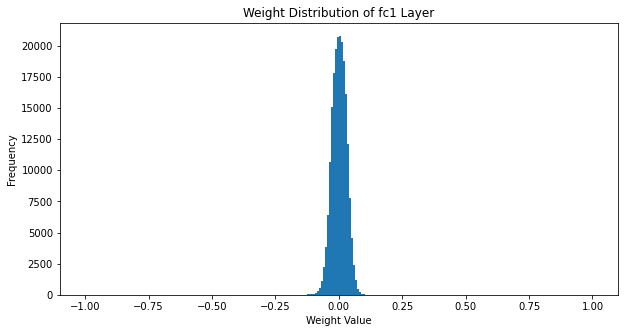

In [21]:
import matplotlib.pyplot as plt
# get the weights and bias of every layer in the network and put it in one array
w = net.fc1.weight.detach().cpu().numpy()
b = net.fc1.bias.detach().cpu().numpy()
w = np.concatenate((w.flatten(), b.flatten()), axis=0)
w2 = net.fc2.weight.detach().cpu().numpy()
b2 = net.fc2.bias.detach().cpu().numpy()
w2 = np.concatenate((w2.flatten(), b2.flatten()), axis=0)
a = np.concatenate((w, w2), axis=0)

# find absolute max and min of the weights and bias
max_val = np.max(a)
min_val = np.min(a)
print("Max weight: ", max_val)
print("Min weight: ", min_val)


plt.figure(figsize=(10, 5))
plt.title("Weight Distribution of fc1 Layer")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.grid(False)

plt.hist(a.flatten(), bins=256, range=(-1, 1))

In [17]:
Q07_SCALE = 128.0
Q07_MAX_FLOAT = 127 / 128.0    # 0.9921875
Q07_MIN_FLOAT = -1.0
Q07_MAX_INT8 = 127
Q07_MIN_INT8 = -128

def quantize_q07(x: float) -> int:
    if x > Q07_MAX_FLOAT:
        x = Q07_MAX_FLOAT
    elif x < Q07_MIN_FLOAT:
        x = Q07_MIN_FLOAT

    scaled = int(x * Q07_SCALE + (0.5 if x >= 0 else -0.5))

    if scaled > Q07_MAX_INT8:
        scaled = Q07_MAX_INT8
    elif scaled < Q07_MIN_INT8:
        scaled = Q07_MIN_INT8

    return np.int8(scaled)

def quantize_tensor_q07(tensor: torch.Tensor):
    tensor_np = tensor.detach().cpu().numpy()
    quantized = np.vectorize(quantize_q07)(tensor_np).astype(np.int8)
    return quantized

def format_c_array(var_name: str, array: np.ndarray) -> str:
    shape = array.shape
    dims = ''.join([f"[{d}]" for d in shape])
    result = f"const int8_t {var_name}{dims} = {{\n"

    if array.ndim == 1:
        result += "    { " + ', '.join(str(v) for v in array) + " }\n"
    elif array.ndim == 2:
        for row in array:
            result += "    { " + ', '.join(str(v) for v in row) + " },\n"
    elif array.ndim == 3:
        for mat in array:
            result += "    {\n"
            for row in mat:
                result += "        { " + ', '.join(str(v) for v in row) + " },\n"
            result += "    },\n"
    else:
        raise ValueError(f"Unsupported tensor dimension: {array.ndim}")

    result += "};\n\n"
    return result

def write_c_header(model: torch.nn.Module, header_path: str):
    with open(header_path, 'w') as f:
        f.write("// Auto-generated Q0.7 quantized weights\n\n")
        f.write("#ifndef Q07_WEIGHTS_H\n#define Q07_WEIGHTS_H\n\n")
        f.write("#include <stdint.h>\n\n")

        for name, param in model.named_parameters():
            q_data = quantize_tensor_q07(param)
            c_name = name.replace('.', '_')
            f.write(f"// Shape: {q_data.shape}\n")
            f.write(format_c_array(c_name, q_data))

        f.write("#endif // Q07_WEIGHTS_H\n")

In [13]:
q = quantize_tensor_q07(net.fc1.weight)
b = quantize_tensor_q07(net.fc1.bias)
q2 = quantize_tensor_q07(net.fc2.weight)
b2 = quantize_tensor_q07(net.fc2.bias)
np.savetxt("weights_fc1_q07.txt", q)
np.savetxt("bias_fc1_q07.txt", b)
np.savetxt("weights_fc2_q07.txt", q2)
np.savetxt("bias_fc2_q07.txt", b2)


In [18]:
write_c_header(net, "q07_weights.h")